## Error plot with respect to $\beta$

In [1]:
using LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions
using RandomMatrices,Plots,LaTeXStrings,TypedTables,StatsBase,FFTW

To compute the errors, we treat the following as the ground truths.

In [2]:
TW2=TracyWidom;
F1=Fun(x->cdf(TW2,x; beta=1,num_points=300),-10..13);
F2=Fun(x->cdf(TW2,x; beta=2,num_points=300),-10..13);
F4=Fun(x->cdf(TW2,x; beta=4,num_points=300),-10..13);
f1=F1';
f2=F2';
f4=F4';

In [3]:
function TW(β;cheb=10^3,method="finite",interp=true,step="trapz",pdf=false,x0=13.0/(sqrt(β)),xN=-10.0,Δx_f=-0.001,Δx_s=-0.001,M_f=Int(floor(-1/(Δx_f))),M_s=8000,l=10)
    
    # Set up the time domain
    if method=="finite"
        xs=time_gen(x0,xN,Δx_f)
    elseif method=="spectral"
        xs=time_gen(x0,xN,Δx_s)
    end
    xl=length(xs)
    
    # Set up the initial conditions
    (c0,c1,c2,c3,c4,c5,h,θ)=initial_gen(β;method,x0,Δx_f,Δx_s,M_f,M_s,l)

    # Set up the matrices
    (A,B)=matrix_gen(β;method,M_f,M_s,h,θ,l)

    # Step forward in time
    (TW_cdf,TW_pdf)=step_for(method,step,A,B,x0,M_s,xs,xl,c0,c1,c2,c3,c4,c5,l)

    # Interpolation
    (cdf_cheb,pdf_cheb)=Fourier_interp(xs,cheb,TW_cdf,TW_pdf)
    
    if interp && pdf==false
        return cdf_cheb
    elseif interp && pdf
        return pdf_cheb
    elseif interp==false && pdf==false
        return xs,TW_cdf
    elseif interp==false && pdf
        return xs,TW_pdf
    else
        return "Input valid arguments"
    end
end

TW (generic function with 1 method)

In [4]:
function time_gen(x1,x2,Δx)
    xs=x1:Δx:x2 |> Array
    if abs(xs[end])<abs(x2)
        xs=x1:Δx:(x2+Δx) |> Array
    end
    return xs
end

time_gen (generic function with 1 method)

In [5]:
function initial_gen(β;method,x0,Δx_f,Δx_s,M_f,M_s,l)
    Φ = x -> erf.(x/sqrt(2))/2 + 0.5
    dϕ = x -> exp.(-x^2/2)*1/sqrt(2pi)
    g = (x0,β,t) -> Φ( (x0 - cot(t).^2)./sqrt.(4/β * cot.(t)) )
    h0 = (x0,β,t) -> t < pi/2 ? g(x0,β,t) : 1.0
    chain = (x0,β,t) -> (x0 + 3*cot.(t).^2).*csc.(t).*sec.(t)./sqrt.(16/β * cot.(t))
    dg = (x0,β,t) -> t ≈ 0.0 ? 0.0 : dϕ((x0 - cot(t).^2)./sqrt(4/β * cot.(t))).*chain(x0,β,t)
    dh0 = (x0,β,t) -> t < pi/2 ? dg(x0,β,t) : 0.0
    mfft = x -> fftshift(fft(x))/length(x)

    if method=="finite"
        mgrid=(n,L) -> L*(1:n)/n
        θ=mgrid(M_f,pi)
        h=(1/M_f)*pi
        c0=map(t -> h0(x0,β,t),θ)
        c1=map(t -> h0(x0-Δx_f,β,t),θ)
        c2=map(t -> h0(x0-2*Δx_f,β,t),θ)
        c3=map(t -> h0(x0-3*Δx_f,β,t),θ)
        c4=map(t -> h0(x0-4*Δx_f,β,t),θ)
        c5=map(t -> h0(x0-5*Δx_f,β,t),θ)
    elseif method=="spectral"
        mgrid = (n,L) -> 2*L*(0:n-1)/n
        θ=mgrid(M_s,l*pi)
        h=(1/M_s)*2*l*pi
        c0=map(t -> dh0(x0,β,t),θ)|>mfft
        c1=map(t -> dh0(x0-Δx_s,β,t),θ)|>mfft
        c2=map(t -> dh0(x0-2*Δx_s,β,t),θ)|>mfft
        c3=map(t -> dh0(x0-3*Δx_s,β,t),θ)|>mfft
        c4=map(t -> dh0(x0-4*Δx_s,β,t),θ)|>mfft
        c5=map(t -> dh0(x0-5*Δx_s,β,t),θ)|>mfft
    end
    return c0,c1,c2,c3,c4,c5,h,θ
end

initial_gen (generic function with 1 method)

In [6]:
function matrix_gen(β;method,M_f,M_s,h,θ,l)
    diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j
    function 𝒟(L,m,j)
        spdiagm(diffvec(L,m,j))
    end
    if method=="finite"
        T=spdiagm(0=>fill(-2.0,M_f),1=>fill(1.0,M_f-1),-1=>fill(1.0,M_f-1))
        tt=(-2*(sin.(θ)).^4)/(β*(h^2))
        T=spdiagm(0=>vec(tt))*T
        um1=ones(Int64,M_f-2,1);um1=vcat(um1,4);ud=zeros(Int64,M_f-1,1);ud=vcat(ud,-3);um2=zeros(Int64,M_f-3,1);um2=vcat(um2,-1)
        U=spdiagm(0=>vec(ud),1=>fill(-1.0,M_f-1),-1=>vec(um1),-2=>vec(um2))
        tt2=(1/(2*h))*((2*sin.(2*θ)/β).*(sin.(θ)).^2-(cos.(θ)).^2)
        A=T+spdiagm(0=>vec(tt2))*U
        uu=(1/(2*h))*(sin.(θ)).^2
        B=spdiagm(0=>vec(uu))*U
    elseif method=="spectral"
        mme = spdiagm( l => fill(1.0,M_s-l), l-M_s => fill(1.0,l))
        me = spdiagm( -l => fill(1.0,M_s-l), M_s-l => fill(1.0,l))
        ms = (me - mme)/2im;
        ms2 = (me^2 - mme^2)/2im;
        mc = (me + mme)/2;
        mc2 = (me^2 + mme^2)/2;
        DD = 𝒟(l*pi,M_s,1) |> sparse;
        A = (-2/β)*ms^4*DD^2 - (8/β)*ms^3*mc*DD - (2/β)*ms2*ms^2*DD + mc^2*DD - (4/β)*(ms*mc*ms2 + ms^2*mc2) - 2*mc*ms;
        B = -ms^2*DD - 2*ms*mc
    end
    return A,B
end

matrix_gen (generic function with 1 method)

In [7]:
function step_for(method,step,A,B,x0,M_s,xs,xl,c0,c1,c2,c3,c4,c5,l;x33=0.4358665215,α=(2/sqrt(3))*cos(π/18),x34=1.06858)
    TW_cdf=zeros(xl,1)
    TW_pdf=zeros(xl,1)
    TW_cdf[1]=1
    TW_pdf[1]=0
    Δx=xs[2]-xs[1]
    N=-floor(M_s/2):1:floor((M_s-1)/2)
    integ=zeros(ComplexF64,length(N))
    for j=1:length(N)
        if N[j]==0
            integ[j]=pi
        else
            integ[j]=l/(im*N[j])*(exp(im*N[j]*pi/l)-1)
        end
    end
    if step=="trapz"
        for i=1:xl-1
            rhs=(I+(Δx/2)*(A+xs[i]*B))*c0
            lhs=I-(Δx/2)*(A+xs[i+1]*B)
            c0=lhs\rhs
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irk22"    #TR-BDF2
        for i=1:xl-1
            rhs=(I+(Δx/4)*(A+xs[i]*B))*c0
            lhs=I-(Δx/4)*(A+(xs[i]+(Δx/2))*B)
            temp=lhs\rhs
            rhs=(4/3)*temp-(1/3)*c0
            lhs=I-(Δx/3)*(A+xs[i+1]*B)
            c0=lhs\rhs
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irk23"   #Two-stage third-order
        for i=1:xl-1
            rhs1=c0
            lhs1=I-Δx*(1/2+sqrt(3)/6)*(A+(xs[i]+Δx*(1/2+sqrt(3)/6))*B)
            temp1=lhs1\rhs1
            rhs2=c0-(sqrt(3)/3)*Δx*(A+(xs[i]+Δx*(1/2+sqrt(3)/6))*B)*temp1
            lhs2=I-Δx*(1/2+sqrt(3)/6)*(A+(xs[i]+Δx*(1/2-sqrt(3)/6))*B)
            temp2=lhs2\rhs2
            c0=c0+(Δx/2)*((A+(xs[i]+Δx*(1/2+sqrt(3)/6))*B)*temp1+(A+(xs[i]+Δx*(1/2-sqrt(3)/6))*B)*temp2)
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irk33"    #Three-stage third-order
        for i = 1:xl - 1
            rhs1 = c0 
            lhs1 = I-x33*Δx*(A+(xs[i]+x33*Δx)*B)
            temp1 = lhs1\rhs1
            rhs2 = c0+Δx*((1-x33)/2)*(A+(xs[i]+x33*Δx)*B)*temp1
            lhs2 = I-x33*Δx*(A+(xs[i]+((1+x33)/2)*Δx)*B)
            temp2 = lhs2\rhs2
            rhs3 = c0+Δx*(-3*x33^2/2+4*x33-1/4)*(A+(xs[i]+x33*Δx)*B)*temp1+Δx*(3*x33^2/2-5*x33+5/4)*(A+(xs[i]+((1+x33)/2)*Δx)*B)*temp2
            lhs3 = I-x33*Δx*(A+xs[i+1]*B)
            c0 = lhs3\rhs3
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irk43"     #Four-stage third-order
        for i=1:xl-1
            rhs1=c0
            lhs1=I-(Δx/2)*(A+(xs[i]+Δx/2)*B)
            temp1=lhs1\rhs1
            rhs2=c0+(Δx/6)*(A+(xs[i]+Δx/2)*B)*temp1
            lhs2=I-(Δx/2)*(A+(xs[i]+2*Δx/3)*B)
            temp2=lhs2\rhs2
            rhs3=c0-(Δx/2)*(A+(xs[i]+Δx/2)*B)*temp1+(Δx/2)*(A+(xs[i]+2*Δx/3)*B)*temp2
            lhs3=I-(Δx/2)*(A+(xs[i]+Δx/2)*B)
            temp3=lhs3\rhs3
            rhs4=c0+(3*Δx/2)*(A+(xs[i]+Δx/2)*B)*temp1-(3*Δx/2)*(A+(xs[i]+2*Δx/3)*B)*temp2+(Δx/2)*(A+(xs[i]+Δx/2)*B)*temp3
            lhs4=I-(Δx/2)*(A+xs[i+1]*B)
            c0=lhs4\rhs4
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irk34"       #Three-stage fourth-order
        for i=1:xl-1
            rhs1 = c0
            lhs1 = I-Δx*((1+α)/2)*(A+(xs[i]+((1+α)/2)*Δx)*B)
            temp1 = lhs1\rhs1
            rhs2 = c0-(α/2)*Δx*(A+(xs[i]+Δx*((1+α)/2))*B)*temp1
            lhs2 = I-Δx*((1+α)/2)*(A+(xs[i]+Δx/2)*B)
            temp2 = lhs2\rhs2
            rhs3 = c0+Δx*(1+α)*(A+(xs[i]+Δx*((1+α)/2))*B)*temp1-Δx*(1+2*α)*(A+(xs[i]+Δx/2)*B)*temp2
            lhs3 = I-Δx*((1+α)/2)*(A+(xs[i]+((1-α)/2)*Δx)*B)
            temp3 = lhs3\rhs3
            c0 = c0+(Δx/(6*α^2))*(A+(xs[i]+((1+α)/2)*Δx)*B)*temp1+Δx*(1-(1/(3*α^2)))*(A+(xs[i]+Δx/2)*B)*temp2+(Δx/(6*α^2))*(A+(xs[i]+((1-α)/2)*Δx)*B)*temp3
            c0_pdf=(A+xs[i+1]*B)*c0    
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="irkn34"       #Three-stage fourth-order 
        for i=1:xl-1 
            rhs1 = c0
            lhs1 = I-Δx*x34*(A+(xs[i]+x34*Δx)*B)
            temp1 = lhs1\rhs1
            rhs2 = c0+(1/2-x34)*Δx*(A+(xs[i]+Δx*x34)*B)*temp1
            lhs2 = I-Δx*x34*(A+(xs[i]+Δx/2)*B)
            temp2 = lhs2\rhs2
            rhs3 = c0+Δx*2*x34*(A+(xs[i]+Δx*x34)*B)*temp1+Δx*(1-4*x34)*(A+(xs[i]+Δx/2)*B)*temp2
            lhs3 = I-Δx*x34*(A+(xs[i]+(1-x34)*Δx)*B)
            temp3 = lhs3\rhs3
            c0 = c0+(Δx/(6*(1-2*x34)^2))*(A+(xs[i]+x34*Δx)*B)*temp1+Δx*(((3*(1-2*x34)^2)-1)/(3*(1-2*x34)^2))*(A+(xs[i]+Δx/2)*B)*temp2+(Δx/(6*(1-2*x34)^2))*(A+(xs[i]+(1-x34)*Δx)*B)*temp3
            c0_pdf = (A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1] = c0[end]
                TW_pdf[i+1] = c0_pdf[end]
            end
        end
    elseif step=="bdf3"
        RR = (A+(x0*B))*(6Δx)
        IRR = 11I - RR
        ΔRR = (6Δx^2)*B
        for i = 1:xl-1
            temp = 18c0 - 9c1 + 2c2
            c2 = c1
            c1 = c0
            IRR -= ΔRR
            c0 = IRR\temp
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1]=c0[end]
                TW_pdf[i+1]=c0_pdf[end]
            end
        end
    elseif step=="bdf4"
        RR = (A+(x0*B))*(12Δx)
        IRR = 25I - RR
        ΔRR = (12Δx^2)*B
        for i = 1:xl-1
            temp = 48c0 - 36c1 + 16c2 - 3c3
            c3 = c2
            c2 = c1
            c1 = c0
            IRR -= ΔRR
            c0 = IRR\temp
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1]=c0[end]
                TW_pdf[i+1]=c0_pdf[end]
            end
        end
    elseif step=="bdf5"
        RR = (A+(x0*B))*(60Δx)
        IRR = 137I - RR
        ΔRR = (60Δx^2)*B
        for i = 1:xl-1
            temp = 300c0 - 300c1 + 200c2 - 75c3 + 12c4
            c4 = c3
            c3 = c2
            c2 = c1
            c1 = c0
            IRR -= ΔRR
            c0 = IRR\temp
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1]=c0[end]
                TW_pdf[i+1]=c0_pdf[end]
            end
        end
    elseif step=="bdf6"
        RR = (A+(x0*B))*(60Δx)
        IRR = 147I - RR
        ΔRR = (60Δx^2)*B
        for i = 1:xl-1
            temp = 360c0 - 450c1 + 400c2 - 225c3 + 72c4 - 10c5
            c5 = c4
            c4 = c3
            c3 = c2
            c2 = c1
            c1 = c0
            IRR -= ΔRR
            c0 = IRR\temp
            c0_pdf=(A+xs[i+1]*B)*c0
            if method=="spectral"
                TW_cdf[i+1] = sum(c0.*integ)|> real
                TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
            elseif method=="finite"
                TW_cdf[i+1]=c0[end]
                TW_pdf[i+1]=c0_pdf[end]
            end
        end
    end
    return TW_cdf,TW_pdf
end

step_for (generic function with 1 method)

In [8]:
function Fourier_interp(xs,cheb,TW_cdf,TW_pdf)  
    ϕ = x -> (erf.(x) .+ 1.0)/2
    j=PeriodicSegment(xs[end],xs[1])
    S=Laurent(j)
    final_pdf=TW_pdf[2:end] |> reverse
    final_cdf=TW_cdf[2:end] |> reverse
    xx=xs[2:end] |> reverse
    f_pdf=Fun(S,ApproxFun.transform(S,final_pdf))
    f_cdf=Fun(S,ApproxFun.transform(S,final_cdf-ϕ(xx)))
    S2=xs[end]..xs[1] |> Chebyshev
    pdf_cheb=Fun(f_pdf,S2,cheb) |> real
    cdf_cheb=Fun(f_cdf,S2,cheb) + Fun(ϕ,S2) |> real
    return cdf_cheb,pdf_cheb
end

Fourier_interp (generic function with 1 method)

The following plot shows how the absolute error (CDF) over the entire domain $x\in\left[-10,13/\sqrt{\beta}\right]$ changes with respect $\beta=1,2,4$. $\Delta x=-0.001$ and $M=8000$ are used.

In [ ]:
function errs_cdf(D1,D2,D4)
    ers_cdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_cdf=TW(β;method="spectral",step="bdf5")
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            ers_cdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],
                xticks=D1[end]:2:D1[1],legend=:bottomleft)
        elseif β==2
            ers_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],
                xticks=D1[end]:2:D1[1],legend=:bottomleft)
        elseif β==4
            ers_cdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-15),10^(-14),10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),
                    10^(-6),10^(-5)],
                xticks=D1[end]:2:D1[1],legend=:bottomleft)
        end
    end
    return ers_cdf
end

In [ ]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
ers_cdf=errs_cdf(D1,D2,D4)

The following code outputs a table showing the absolute errors of BDF5 for $x=0,\pm 2,\pm 4,\pm 6, \pm 8$, $\beta=1,2,4$, $\Delta x=-0.001$, $M=8000$.

In [ ]:
X=-8:2:6;
err=zeros(length(X),3);
B=[1,2,4];
for i=1:length(B)
    global β=B[i]
    F_cdf=TW(β;method="spectral",step="bdf5")
    for j=1:length(X)
        temp=X[j]
        if β==4
            err[j,3]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
        elseif β==1
            err[j,1]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
        elseif β==2
            err[j,2]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
        end
    end
end
err1=err[:,1];err2=err[:,2];err4=err[:,3];

In [ ]:
Table(x=X,β1=err1,β2=err2,β4=err4)

Similarly, the following plot is for the PDF.

In [ ]:
function errs_pdf(D1,D2,D4)
    ers_pdf=Plots.plot();
    beta=[1,2,4];
    err1=zeros(length(D1),1);
    err2=zeros(length(D2),1);
    err4=zeros(length(D4),1);
    for j=1:length(beta)
        global β=beta[j]
        F_pdf=TW(β;method="spectral",step="bdf5",pdf=true,Δx_f=-0.001)
        if β==1
            for i=1:length(D1)
                temp=D1[i]
                err1[i]=abs(F_pdf(temp)-f1(temp))
            end
        elseif β==2
            for i=1:length(D2)
                temp=D2[i]
                err2[i]=abs(F_pdf(temp)-f2(temp))
            end
        elseif β==4
            for i=1:length(D4)
                temp=D4[i]
                err4[i]=abs(F_pdf(temp/(2^(1/6)))*(2^(-1/6))-f4(temp))
            end
        end
        for i=1:length(D1)
            if err1[i]<10^(-16)
                err1[i]=10^(-16)
            end
        end
        for i=1:length(D2)
            if err2[i]<10^(-16)
                err2[i]=10^(-16)
            end
        end
        for i=1:length(D4)
            if err4[i]<10^(-16)
                err4[i]=10^(-16)
            end
        end
        if β==1
            ers_pdf=Plots.plot!(D1,err1,lw=5,label=L"$\beta=1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==2
            ers_pdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        elseif β==4
            ers_pdf=Plots.plot!(D4,err4,lw=5,label=L"$\beta=4$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=10,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],
                xticks=D1[end]:2:D1[1],legend=:topright)
        end
    end
    return ers_pdf
end

In [ ]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
D4=6.5:-0.05:-10;
ers_pdf=errs_pdf(D1,D2,D4)

## Error plots with respect to $\left|\Delta x\right|$ and $M$

The following plots show how the absolute error (CDF) over the entire domain $x\in\left[-10,13/\sqrt{\beta}\right]$ changes when $\left|\Delta x\right|$ decreases and $M$ increases for a fixed $\beta$-value. $\Delta x=-0.2,-0.1,-0.05$ and $M=8000$ are used.

In [ ]:
function errs_cdfc(β,D)
    ers_cdfc=Plots.plot();
    delta_x=[-0.2,-0.1,-0.05];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_cdf=TW(β;method="spectral",step="bdf5",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=4,num_points=300))
            elseif β==1
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=1,num_points=300))
            elseif β==2
                err[i]=abs(F_cdf(temp)-cdf(TW2,temp;beta=2,num_points=300))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10),10^(12),10^(14),10^(16)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10),10^(12),10^(14),10^(16)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            ers_cdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.05$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,
                legendfontsize=15,yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),
                    10^(6),10^(8),10^(10),10^(12),10^(14),10^(16)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return ers_cdfc
end

For $\beta=1$, we have

In [ ]:
D=13:-0.05:-10;
ers_cdfc=errs_cdfc(1,D)

For $\beta=2$, we have

In [ ]:
D=13/sqrt(2):-0.05:-10;
ers_cdfc=errs_cdfc(2,D)

For $\beta=4$, we have

In [ ]:
D=6.5:-0.05:-10;
ers_cdfc=errs_cdfc(4,D)

Similarly, the following algorithm is for the PDF.

In [ ]:
function errs_pdfc(β,D)
    ers_pdfc=Plots.plot();
    delta_x=[-0.2,-0.1,-0.05];
    for j=1:length(delta_x)
        err=zeros(length(D),1)
        dx=delta_x[j];
        F_pdf=TW(β;pdf=true,method="spectral",step="bdf5",Δx_s=dx)
        for i=1:length(D)
            temp=D[i]
            if β==4
                err[i]=abs(F_pdf(temp/(2^(1/6)))*(2^(-1/6))-f4(temp))
            elseif β==1
                err[i]=abs(F_pdf(temp)-f1(temp))
            elseif β==2
                err[i]=abs(F_pdf(temp)-f2(temp))
            end
        end
        for i=1:length(D)
            if err[i]<10^(-16)
                err[i]=10^(-16)
            end
        end
        if j==1
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==2
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.1$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        elseif j==3
            ers_pdfc=Plots.plot!(D,err,lw=5,label=L"$\Delta x=-0.05$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
                yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2),10^(0),10^(2),10^(4),10^(6),10^(8),
                    10^(10)],xticks=ceil(D[end]):2:floor(D[1]),legend=:bottom)
        end
    end
    return ers_pdfc
end

For $\beta=1$, we have

In [ ]:
D=13:-0.05:-10;
ers_pdfc=errs_pdfc(1,D)

For $\beta=2$, we have

In [ ]:
D=13/sqrt(2):-0.05:-10;
ers_pdfc=errs_pdfc(2,D)

For $\beta=4$, we have

In [ ]:
D=6.5:-0.05:-10;
ers_pdfc=errs_pdfc(4,D)

## Order of error plot

The following plot shows the order of error of the spectral discretization (CDF) using trapezoidal method for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025$ are used.

In [9]:
β=2;
xx=-2;
result_ref=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="trapz",interp=false,Δx_s=-0.001);
x_ref=result_ref[1];F_ref=result_ref[2];ind=findall(x -> x == xx, x_ref)[1];

In [10]:
del_x=[-0.05,-0.04,-0.025];
err=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="trapz",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind2=findall(x -> x == xx, x_cdf)[1];
    err[i]=abs(F_cdf[ind2]-F_ref[ind]);
end

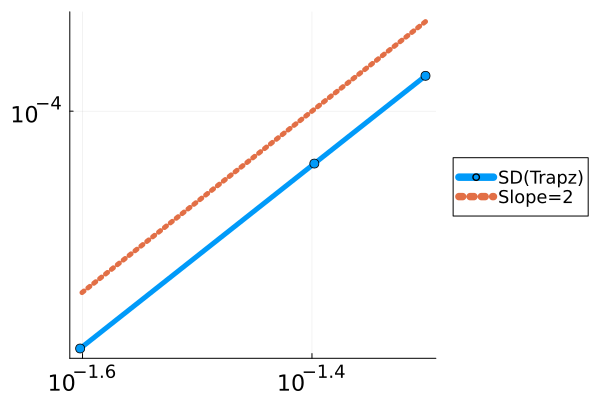

In [57]:
p=Plots.plot();
p=plot!(del_x.*(-1),vec(err),lw=5,label="SD(Trapz)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p=plot!(del_x.*(-1),10^(-1.2)*(del_x.*(-1)).^(2),lw=5,label="Slope=2",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF3 for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025$ are used.

In [12]:
β=2;
xx=-2;
result_ref3=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf3",interp=false,Δx_s=-0.001);
x_ref3=result_ref3[1];F_ref3=result_ref3[2];ind3=findall(x -> x == xx, x_ref3)[1];

In [13]:
del_x=[-0.05,-0.04,-0.025];
err3=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf3",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind32=findall(x -> x == xx, x_cdf)[1];
    err3[i]=abs(F_cdf[ind32]-F_ref3[ind3]);
end

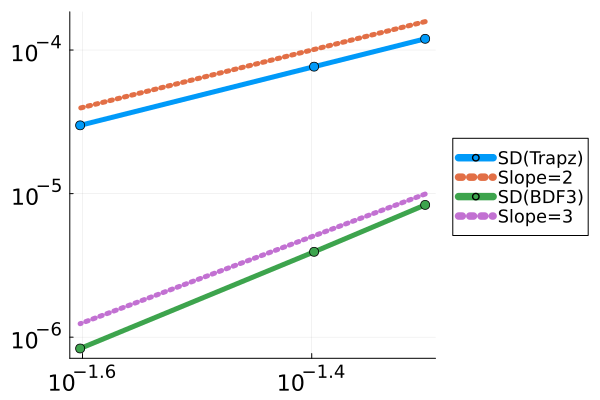

In [58]:
p=plot!(del_x.*(-1),vec(err3),lw=5,label="SD(BDF3)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p=plot!(del_x.*(-1),10^(-1.1)*(del_x.*(-1)).^(3),lw=5,label="Slope=3",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF4 for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.05,-0.04,-0.025$ are used.

In [15]:
β=2;
xx=-2;
result_ref4=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf4",interp=false,Δx_s=-0.001);
x_ref4=result_ref4[1];F_ref4=result_ref4[2];ind4=findall(x -> x == xx, x_ref4)[1];

In [16]:
del_x=[-0.05,-0.04,-0.025];
err4=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf4",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind42=findall(x -> x == xx, x_cdf)[1];
    err4[i]=abs(F_cdf[ind42]-F_ref4[ind4]);
end

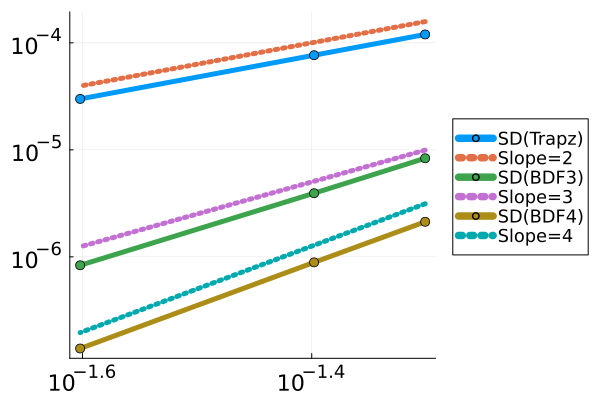

In [59]:
p=plot!(del_x.*(-1),vec(err4),lw=5,label="SD(BDF4)",legend=:outerright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=12)
p=plot!(del_x.*(-1),10^(-0.3)*(del_x.*(-1)).^(4),lw=5,label="Slope=4",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF5 for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.25,-0.2,-0.1$ are used.

In [18]:
β=2;
xx=-2;
result_ref5=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf5",interp=false,Δx_s=-0.001);
x_ref5=result_ref5[1];F_ref5=result_ref5[2];ind5=findall(x -> x == xx, x_ref5)[1];

In [19]:
del_x=[-0.25,-0.2,-0.1];
err5=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf5",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind52=findall(x -> x == xx, x_cdf)[1];
    err5[i]=abs(F_cdf[ind52]-F_ref5[ind5]);
end

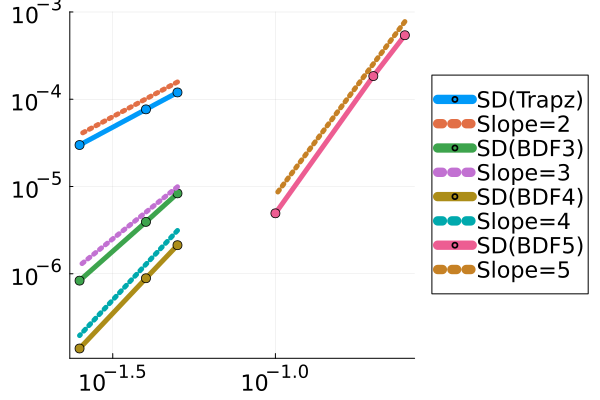

In [61]:
p=plot!(del_x.*(-1),vec(err5),lw=5,label="SD(BDF5)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
p=plot!(del_x.*(-1),10^(-0.1)*(del_x.*(-1)).^(5),lw=5,label="Slope=5",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

The following plot shows the order of error of the spectral discretization (CDF) using BDF6 for $\beta=2$, $x_{0}=\lceil 13/\sqrt{\beta}\rceil$, at $x=-2$ before interpolation with $M=8000$. We treat the case $\Delta x=-0.001$ as the reference to compare with. $\Delta x=-0.4,-0.3,-0.25$ are used.

In [21]:
β=2;
xx=-2;
result_ref6=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf6",interp=false,Δx_s=-0.001);
x_ref6=result_ref6[1];F_ref6=result_ref6[2];ind6=findall(x -> x == xx, x_ref6)[1];

In [22]:
del_x=[-0.4,-0.3,-0.25];
err6=zeros(1,length(del_x));
for i=1:length(del_x)
    dx=del_x[i];
    result_cdf=TW(β;x0=ceil(13/sqrt(β)),method="spectral",step="bdf6",interp=false,Δx_s=dx);
    x_cdf=result_cdf[1];F_cdf=result_cdf[2];
    ind62=findall(x -> x == xx, x_cdf)[1];
    err6[i]=abs(F_cdf[ind62]-F_ref6[ind6]);
end

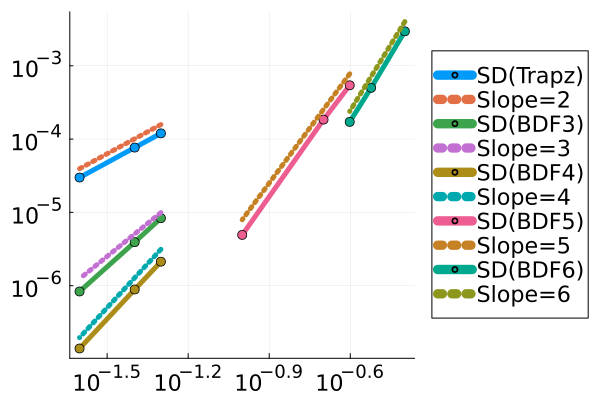

In [63]:
p=plot!(del_x.*(-1),vec(err6),lw=5,label="SD(BDF6)",legend=:bottomright,yaxis=:log10,xaxis=:log10,yticks=[10^(-16),10^(-15),10^(-14),
        10^(-13),10^(-12),10^(-11),10^(-10),10^(-9),10^(-8),10^(-7),10^(-6),10^(-5),10^(-4),10^(-3),10^(-2),10^(-1),1,10],
    marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
p=plot!(del_x.*(-1),10^(-0.01)*(del_x.*(-1)).^(6),lw=5,label="Slope=6",yaxis=:log10,xaxis=:log10,ls=:dot,legend=:outerright)

## Error plots with respect to $x_{0}$

The following plot shows the absolute error of BDF5 after interpolation over $x=-8,-7,\cdots,x_{0}$ with respect to $x_{0}$. $\beta=1,2,4$, $x_{0}=13,12,11,10,9,8,7,6,5,4,3,2$.

In [ ]:
Beta=[1,2,4];
X=[13,12,11,10,9,8,7,6,5,4,3,2];
p=Plots.plot();
for i=1:length(Beta)
    global β=Beta[i];
    err=zeros(1,length(X));
    for j=1:length(X)
        x00=X[j];
        xx=-8:1:x00
        E=zeros(1,length(xx));
        F_cdf=TW(β;x0=x00,method="spectral",step="bdf5",M_s=16000);
        if β==4
            for k=1:length(xx)
                temp=xx[k]
                E[k]=abs(F_cdf(temp/(2^(1/6)))-cdf(TW2,temp;beta=β,num_points=300));
            end
            err[j]=maximum(E);
        else
            for k=1:length(xx)
                temp=xx[k]
                E[k]=abs(F_cdf(temp)-cdf(TW2,temp;beta=β,num_points=300));
            end
            err[j]=maximum(E);
        end
    end
    if β==1
        p=plot!(X,vec(err),lw=5,label=L"$\beta=1$",legend=:topright,yaxis=:log10,xticks=X,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
    elseif β==2
        p=plot!(X,vec(err),lw=5,label=L"$\beta=2$",legend=:topright,yaxis=:log10,xticks=X,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
    elseif β==4
        p=plot!(X,vec(err),lw=5,label=L"$\beta=4$",legend=:topright,yaxis=:log10,xticks=X,yticks=[10^(-16),10^(-14),
            10^(-12),10^(-10),10^(-8),10^(-6),10^(-4),10^(-2)],marker=(:circle,5),xtickfontsize=15,ytickfontsize=15,legendfontsize=15)
    end
end
p